Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 3D Latent Diffusion Model
In this tutorial, we will walk through the process of using the MONAI generative components package to generate synthetic data using Latent Diffusion Models (LDM)  [1, 2]. Specifically, we will focus on training an LDM to create synthetic brain images from the Brats dataset.

[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Pinaya et al. "Brain imaging generation with latent diffusion models" https://arxiv.org/abs/2209.07162

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.amp import GradScaler, autocast
from torch.nn import L1Loss
from tqdm import tqdm

from monai.inferers import LatentDiffusionInferer
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from monai.networks.schedulers import DDPMScheduler

print_config()

/media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.2.dev2304
Numpy version: 1.23.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /media/walter/Storage/Projects/GenerativeModels/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# for reproducibility purposes set a seed
set_determinism(42)

### Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp5nw3g3c4


### Prepare data loader for the training set
Here we will download the Brats dataset using MONAI's `DecathlonDataset` class, and we prepare the data loader for the training set.

In [4]:
batch_size = 2
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image"]),
        transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(keys=["image"], pixdim=(2.4, 2.4, 2.2), mode=("bilinear")),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=(96, 96, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    ]
)
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=8,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')

2023-02-19 09:07:46,210 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-02-19 09:07:46,210 - INFO - File exists: /tmp/tmp5nw3g3c4/Task01_BrainTumour.tar, skipped downloading.
2023-02-19 09:07:46,211 - INFO - Non-empty folder exists in /tmp/tmp5nw3g3c4/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 388/388 [01:32<00:00,  4.21it/s]

Image shape torch.Size([1, 96, 96, 64])


### Visualise examples from the training set

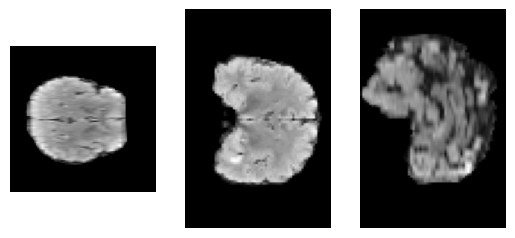

In [5]:
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
idx = 0

img = check_data["image"][idx, 0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
# plt.savefig("training_examples.png")

## Autoencoder KL

### Define Autoencoder KL network

In this section, we will define an autoencoder with KL-regularization for the LDM. The autoencoder's primary purpose is to transform input images into a latent representation that the diffusion model will subsequently learn. By doing so, we can decrease the computational resources required to train the diffusion component, making this approach suitable for learning high-resolution medical images.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [7]:
autoencoder = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 64),
    latent_channels=3,
    num_res_blocks=1,
    norm_num_groups=16,
    attention_levels=(False, False, True),
)
autoencoder.to(device)


discriminator = PatchDiscriminator(spatial_dims=3, num_layers_d=3, channels=32, in_channels=1, out_channels=1)
discriminator.to(device)

### Defining Losses

We will also specify the perceptual and adversarial losses, including the involved networks, and the optimizers to use during the training process.

In [8]:
l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
loss_perceptual = PerceptualLoss(spatial_dims=3, network_type="squeeze", is_fake_3d=True, fake_3d_ratio=0.2)
loss_perceptual.to(device)


def kl_loss(z_mu, z_sigma):
    klloss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3, 4])
    return torch.sum(klloss) / klloss.shape[0]


adv_weight = 0.01
perceptual_weight = 0.001
kl_weight = 1e-6

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.


In [9]:
optimizer_g = torch.optim.Adam(params=autoencoder.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=1e-4)

### Train model

In [10]:
max_epochs = 100
autoencoder_warm_up_n_epochs = 5
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(max_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)  # choose only one of Brats channels

        # Generator part
        optimizer_g.zero_grad(set_to_none=True)
        reconstruction, z_mu, z_sigma = autoencoder(images)
        klloss = kl_loss(z_mu, z_sigma)

        recons_loss = l1_loss(reconstruction.float(), images.float())
        p_loss = loss_perceptual(reconstruction.float(), images.float())
        loss_g = recons_loss + kl_weight * klloss + perceptual_weight * p_loss

        if epoch > autoencoder_warm_up_n_epochs:
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g += adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        if epoch > autoencoder_warm_up_n_epochs:
            # Discriminator part
            optimizer_d.zero_grad(set_to_none=True)
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

            loss_d.backward()
            optimizer_d.step()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

del discriminator
del loss_perceptual
torch.cuda.empty_cache()

Epoch 2: 100%|█████████████████| 194/194 [02:30<00:00,  1.29it/s, recons_loss=0.0337, gen_loss=0, disc_loss=0]
...
Epoch 99: 100%|████████| 194/194 [02:49<00:00,  1.14it/s, recons_loss=0.0225, gen_loss=0.736, disc_loss=0.108]


2023-02-19 13:52:44,991 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


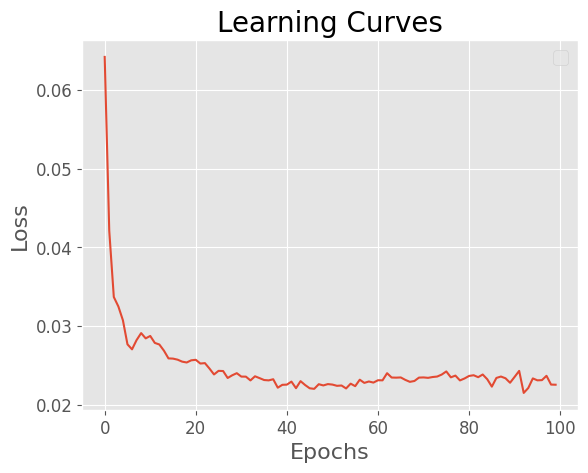

In [11]:
plt.style.use("ggplot")
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch_recon_loss_list)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

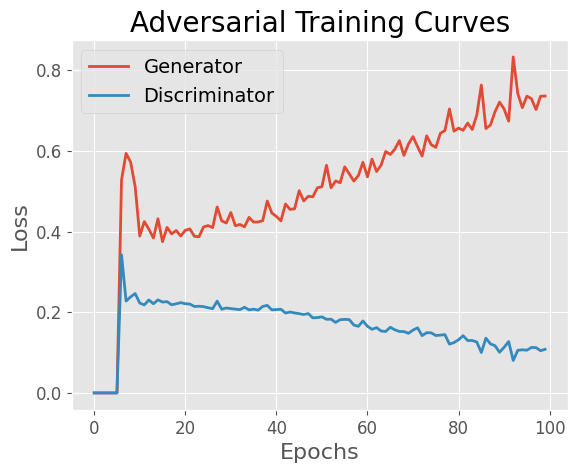

In [12]:
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Visualise reconstructions

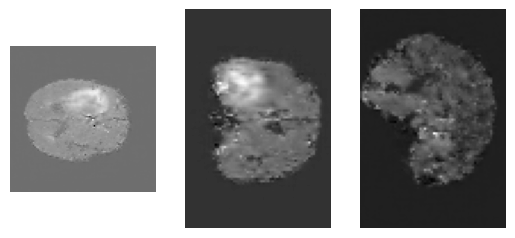

In [13]:
# Plot axial, coronal and sagittal slices of a training sample
idx = 0
img = reconstruction[idx, channel].detach().cpu().numpy()
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")

## Diffusion Model

### Define diffusion model and scheduler

In this section, we will define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Together with the diffusion model, we define a beta scheduler responsible for defining the amount of noise that is added across the diffusion's model Markov chain.

In [42]:
unet = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=3,
    num_res_blocks=1,
    channels=(32, 64, 64),
    attention_levels=(False, True, True),
    num_head_channels=(0, 64, 64),
)
unet.to(device)


scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0015, beta_end=0.0195)

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

_Note: In case where the latent space is close to a Gaussian distribution, the scaling factor will be close to one, and the results will not differ from those obtained when it is not used._


In [14]:
with torch.no_grad():
    with autocast("cuda", enabled=True):
        z = autoencoder.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to tensor(1.0026, device='cuda:0')


We define the inferer using the scale factor:

In [ ]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

In [43]:
optimizer_diff = torch.optim.Adam(params=unet.parameters(), lr=1e-4)

### Train diffusion model

In [44]:
max_epochs = 150
epoch_loss_list = []
autoencoder.eval()
scaler = GradScaler("cuda")

first_batch = first(train_loader)
z = autoencoder.encode_stage_2_inputs(first_batch["image"].to(device))

for epoch in range(max_epochs):
    unet.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_diff.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=True):
            # Generate random noise
            noise = torch.randn_like(z).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(
                inputs=images, autoencoder_model=autoencoder, diffusion_model=unet, noise=noise, timesteps=timesteps
            )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer_diff)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

Epoch 2: 100%|██████████| 194/194 [00:23<00:00,  8.30it/s, loss=0.315]
...
Epoch 149: 100%|████████| 194/194 [00:23<00:00,  8.36it/s, loss=0.266]


## Plotting Learning Curves

2023-02-19 14:12:22,536 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


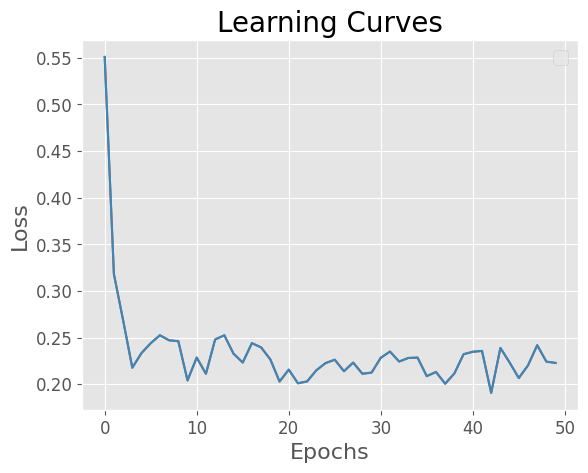

In [18]:
plt.plot(epoch_loss_list)
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch_loss_list)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Plotting sampling example

Finally, we generate an image with our LDM. For that, we will initialize a latent representation with just noise. Then, we will use the `unet` to perform 1000 denoising steps. In the last step, we decode the latent representation and plot the sampled image.

In [51]:
autoencoder.eval()
unet.eval()

noise = torch.randn((1, 3, 24, 24, 16))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
synthetic_images = inferer.sample(
    input_noise=noise, autoencoder_model=autoencoder, diffusion_model=unet, scheduler=scheduler
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.03it/s]


### Visualise synthetic data

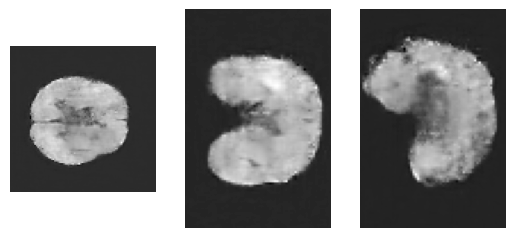

In [52]:
idx = 0
img = synthetic_images[idx, channel].detach().cpu().numpy()  # images
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")

## Cleanup data directory

In [21]:
if directory is None:
    shutil.rmtree(root_dir)